<a href="https://colab.research.google.com/github/pv-912/predict_number/blob/master/ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pandas as pd
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# output all lines

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [0]:
df = pd.read_csv('gdrive/My Drive/learning/predict_number/data/train.csv')
test_data = pd.read_csv('gdrive/My Drive/learning/predict_number/data/test.csv')
sample = pd.read_csv('gdrive/My Drive/learning/predict_number/data/sample.csv')


In [4]:
df.head()
# test.head()

,ID,Tag,Reputation,Answers,Username,Views,Upvotes
0,52664,a,3942.0,2.0,155623,7855.0,42.0
1,327662,a,26046.0,12.0,21781,55801.0,1175.0
2,468453,c,1358.0,4.0,56177,8067.0,60.0
3,96996,a,264.0,3.0,168793,27064.0,9.0
4,131465,c,4271.0,4.0,112223,13986.0,83.0


In [5]:
df.shape
test_data.shape
df.Tag.unique()
df.describe()

(330045, 7)

(141448, 6)

array(['a', 'c', 'r', 'j', 'p', 's', 'h', 'o', 'i', 'x'], dtype=object)

,ID,Reputation,Answers,Username,Views,Upvotes
count,330045.000000,3.300450e+05,330045.000000,330045.000000,3.300450e+05,330045.000000
mean,235748.682789,7.773147e+03,3.917672,81442.888803,2.964507e+04,337.505358
std,136039.418471,2.706141e+04,3.579515,49215.100730,8.095646e+04,3592.441135
min,1.000000,0.000000e+00,0.000000,0.000000,9.000000e+00,0.000000
25%,117909.000000,2.820000e+02,2.000000,39808.000000,2.594000e+03,8.000000
50%,235699.000000,1.236000e+03,3.000000,79010.000000,8.954000e+03,28.000000
75%,353620.000000,5.118000e+03,5.000000,122559.000000,2.687000e+04,107.000000
max,471493.000000,1.042428e+06,76.000000,175738.000000,5.231058e+06,615278.000000


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
!pip install mpld3
import mpld3
mpld3.enable_notebook()
from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import Pipeline

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

%matplotlib inline
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
import xgboost as xgb
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')

sns.set(style='white', context='notebook', palette='deep')

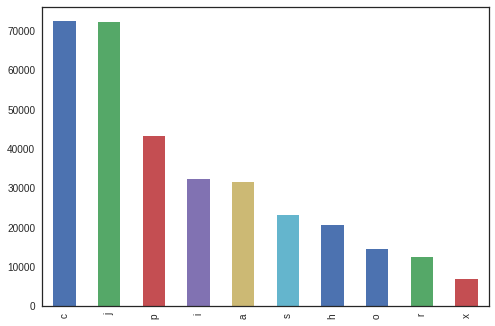

In [8]:
df.Tag.value_counts().plot(kind='bar')


In [9]:
# df.Tag.value_counts(normalize=True).plot(kind='bar')
df.Tag.value_counts()

c    72458
j    72232
p    43407
i    32400
a    31695
s    23323
h    20564
o    14546
r    12442
x     6978
Name: Tag, dtype: int64

In [10]:
corr = df.corr()
corr.style.background_gradient()

,ID,Reputation,Answers,Username,Views,Upvotes
ID,1,0.00854598,0.017448,0.000628416,0.0174005,0.00632819
Reputation,0.00854598,1,0.0665043,-0.0410193,0.0364555,0.26671
Answers,0.017448,0.0665043,1,-0.0121975,0.498642,0.202033
Username,0.000628416,-0.0410193,-0.0121975,1,0.00230564,-0.0119699
Views,0.0174005,0.0364555,0.498642,0.00230564,1,0.437336
Upvotes,0.00632819,0.26671,0.202033,-0.0119699,0.437336,1


In [11]:
df.isnull().values.any()
df.isnull().sum().sum()


False

0

In [0]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


In [0]:
#join dataset for featuring
train_len = len(df)
dataset =  pd.concat(objs=[df, test_data], axis=0).reset_index(drop=True)


In [14]:
#missing values
missing_features = dataset.columns[dataset.isnull().any()]
missing_features

Index(['Upvotes'], dtype='object')

In [15]:
dataset.tail()
dataset = dataset.drop(labels = ["Upvotes"],axis = 1)
dataset.tail()


,Answers,ID,Reputation,Tag,Upvotes,Username,Views
471488,4.0,47187,4681.0,j,NaN,152060,2469.0
471489,3.0,329126,7782.0,j,NaN,89235,18998.0
471490,5.0,282334,435.0,p,NaN,119788,57048.0
471491,3.0,386629,176.0,o,NaN,86824,10193.0
471492,2.0,107271,648.0,a,NaN,102240,12785.0


,Answers,ID,Reputation,Tag,Username,Views
471488,4.0,47187,4681.0,j,152060,2469.0
471489,3.0,329126,7782.0,j,89235,18998.0
471490,5.0,282334,435.0,p,119788,57048.0
471491,3.0,386629,176.0,o,86824,10193.0
471492,2.0,107271,648.0,a,102240,12785.0


In [16]:
label_encoder = LabelEncoder()
temp = dataset.copy()
temp.iloc[:,1] = label_encoder.fit_transform(temp.iloc[:,1])
temp.head()

,Answers,ID,Reputation,Tag,Username,Views
0,2.0,52663,3942.0,a,155623,7855.0
1,12.0,327661,26046.0,a,21781,55801.0
2,4.0,468452,1358.0,c,56177,8067.0
3,3.0,96995,264.0,a,168793,27064.0
4,4.0,131464,4271.0,c,112223,13986.0


In [17]:

from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
X = temp[["Reputation",  "Answers" , "Views"]].values.astype(np.float64)
min_max_scaler = MinMaxScaler()
min_max_scaler.fit_transform(X)
scaled_data = pd.DataFrame(min_max_scaler.fit_transform(X), columns=["Reputation" , "Answers" , "Views"])
scaled_data.head()

#Robust scaler for outliers 


temp.drop(columns=["Reputation", "Answers" , "Views"], axis=1,inplace=True)
temp = pd.concat([temp, scaled_data], axis=1)


array([[0.00378156, 0.02631579, 0.00149989],
       [0.0249859 , 0.15789474, 0.01066555],
       [0.00130273, 0.05263158, 0.00154042],
       ...,
       [0.0004173 , 0.06578947, 0.01090393],
       [0.00016884, 0.03947368, 0.00194684],
       [0.00062163, 0.02631579, 0.00244234]])

,Reputation,Answers,Views
0,0.003782,0.026316,0.001500
1,0.024986,0.157895,0.010666
2,0.001303,0.052632,0.001540
3,0.000253,0.039474,0.005172
4,0.004097,0.052632,0.002672


In [18]:
# df.head()
temp.tail()
# temp1.tail()

,ID,Tag,Username,Reputation,Answers,Views
471488,47186,j,152060,0.004490,0.052632,0.000470
471489,329125,j,89235,0.007465,0.039474,0.003630
471490,282333,p,119788,0.000417,0.065789,0.010904
471491,386628,o,86824,0.000169,0.039474,0.001947
471492,107270,a,102240,0.000622,0.026316,0.002442


In [19]:
onehot = pd.get_dummies(temp.iloc[:,1],  prefix='tag')
onehot.head()

,tag_a,tag_c,tag_h,tag_i,tag_j,tag_o,tag_p,tag_r,tag_s,tag_x
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0


In [20]:
temp = pd.concat([temp,onehot], axis = 1)
temp = temp.drop(labels = ["Tag","ID", "Username"],axis = 1)
# temp = temp.drop(labels = ["tag_a","tag_c","tag_h","tag_i","tag_j","tag_o","tag_p","tag_r","tag_s","tag_x"],axis = 1)

temp.head()

,Reputation,Answers,Views,tag_a,tag_c,tag_h,tag_i,tag_j,tag_o,tag_p,tag_r,tag_s,tag_x
0,0.003782,0.026316,0.001500,1,0,0,0,0,0,0,0,0,0
1,0.024986,0.157895,0.010666,1,0,0,0,0,0,0,0,0,0
2,0.001303,0.052632,0.001540,0,1,0,0,0,0,0,0,0,0
3,0.000253,0.039474,0.005172,1,0,0,0,0,0,0,0,0,0
4,0.004097,0.052632,0.002672,0,1,0,0,0,0,0,0,0,0


In [21]:
N = RobustScaler()
N.fit(temp)

temp = N.transform(temp)

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)

In [22]:
X_train = temp[:train_len]
Y_train = df['Upvotes']

test = temp[train_len:]
X_train

array([[ 0.55902419, -0.33333333, -0.0455144 , ...,  0.        ,
         0.        ,  0.        ],
       [ 5.12879884,  3.        ,  1.92757202, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.02480877,  0.33333333, -0.03679012, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.02129419, -0.33333333, -0.26781893, ...,  0.        ,
         0.        ,  0.        ],
       [-0.23754393, -0.33333333, -0.28205761, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.1577424 ,  0.33333333, -0.26366255, ...,  0.        ,
         0.        ,  0.        ]])

In [0]:
lassocv = LassoCV(eps=1e-7) 
ridge = Ridge(alpha=1e-6) 
lassolarscv = LassoLarsCV()
elasticnetcv = ElasticNetCV(eps=1e-15)

pipeline = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])



In [0]:
def RMSE(estimator,X_train, Y_train, cv=5,n_jobs=4):
    cv_results = cross_val_score(estimator,X_train,Y_train,cv=cv,scoring="neg_mean_squared_error",n_jobs=n_jobs)
    return (np.sqrt(-cv_results)).mean()

In [27]:
RMSE(lassocv, X_train, Y_train)
RMSE(ridge, X_train, Y_train)
RMSE(lassolarscv, X_train, Y_train)
RMSE(elasticnetcv, X_train, Y_train)
RMSE(pipeline, X_train, Y_train)


3063.794758266583

3063.801811060518

3063.7454932864357

3063.7363783388246

1186.394880233763

In [28]:
lassocv.fit(X_train,Y_train)
ridge.fit(X_train,Y_train)
lassolarscv.fit(X_train,Y_train)
elasticnetcv.fit(X_train,Y_train)
pipeline = pipeline.fit(X_train, Y_train)

LassoCV(alphas=None, copy_X=True, cv='warn', eps=1e-07, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

Ridge(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

LassoLarsCV(copy_X=True, cv='warn', eps=2.220446049250313e-16,
      fit_intercept=True, max_iter=500, max_n_alphas=1000, n_jobs=None,
      normalize=True, positive=False, precompute='auto', verbose=False)

ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=1e-15,
       fit_intercept=True, l1_ratio=0.5, max_iter=1000, n_alphas=100,
       n_jobs=None, normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [0]:
Y_pred_lassocv = lassocv.predict(test)
Y_pred_lassolarscv =lassolarscv.predict(test)
Y_pred_elasticnetcv =elasticnetcv.predict(test)
Y_pred_pipeline = pipeline.predict(test)

# y_pred10 = model.predict(X_test)
# dfp['10'] = y_pred10

# print(np.sqrt(metrics.mean_squared_error(y_test, y_pred10)))

In [33]:
maxi = pd.DataFrame( ((Y_pred_lassocv*0.1 + Y_pred_elasticnetcv*0.05 + Y_pred_lassolarscv*0.05 + Y_pred_pipeline*0.8)), columns=[ "Upvotes" ])
maxi.head()



,Upvotes
0,239.149732
1,142.102917
2,53.369280
3,-4.587585
4,378.445088


In [34]:
submission = pd.concat([test_data['ID'], maxi['Upvotes']], axis=1, keys=['ID', 'Upvotes'])
submission.head()
submission.to_csv('/sub.csv')

,ID,Upvotes
0,366953,239.149732
1,71864,142.102917
2,141692,53.369280
3,316833,-4.587585
4,440445,378.445088
